In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.optimize import curve_fit

In [2]:
a, a_err = 3.1304347826086867e-06, 3.1304347826086867e-06
resolution, resolution_err = 0.018835915624440338, 0.00012187430782578249
c = 360/25600

In [3]:
def gaussian2d(xdata, A, mu_x, mu_y, sigma, C):
    return A * np.exp(-((xdata[0] - mu_x) ** 2 + (xdata[1] - mu_y) ** 2) / (2 * sigma ** 2)) + C

## Data

In [4]:
data = pd.read_csv(
    './data/challenge_raw.csv', 
    comment='#',
    skip_blank_lines=True,
    skipinitialspace=True,
    header=None,
    names=['x', 'theta', 'time', 'ch1', 'ch2', 'coincidences']
)

data['x'] *= a
data['theta'] *= c
data = data[data['theta'] != 171]

x = np.sort(data['x'].unique())
theta = np.sort(data['theta'].unique())  # in degrees

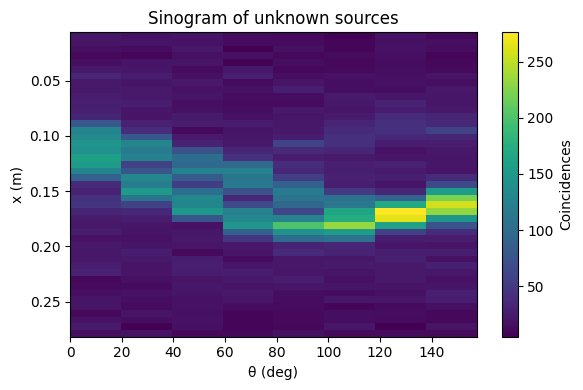

In [5]:
# 2. Pivot into sinogram array
sinogram_df = data.pivot(
    index='x',
    columns='theta',
    values='coincidences'
)
sinogram = sinogram_df.loc[x, theta].values
sinogram = np.roll(sinogram, -5, axis=0)

# 3. Display the sinogram
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(
    sinogram,
    aspect='auto',
    extent=[
        theta.min(), theta.max(),
        x.max(), x.min()
    ]
)
ax.set_xlabel("θ (deg)")
ax.set_ylabel("x (m)")
ax.set_title("Sinogram of unknown sources")

fig.colorbar(img, ax=ax, label='Coincidences')
plt.tight_layout()

fig.savefig('./figures/challenge_sinogram.pdf')

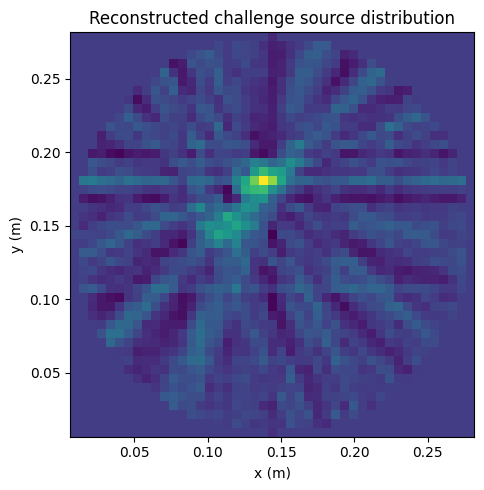

In [6]:
# 4. Perform filtered back‐projection (inverse Radon transform)
reconstruction = iradon(sinogram, theta=theta)

# 5. Display the reconstruction

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(
    reconstruction,
    extent=[x.min(), x.max(), x.min(), x.max()]
)

ax.set_title('Reconstructed challenge source distribution')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

plt.tight_layout()
fig.savefig('./figures/challenge_reconstruction.pdf')

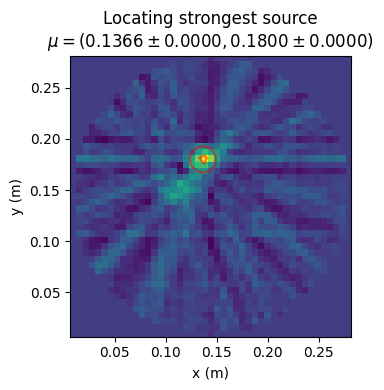

In [15]:
fig, ax = plt.subplots(figsize=(4 , 4))

# Plot reconstruction

ax.imshow(
    reconstruction,
    extent=[x.min(), x.max(), x.min(), x.max()]
)
ax.set_title('Source')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

# Fit gaussian

x_grid, y_grid = np.meshgrid(x, x[::-1],)

peak_max = np.unravel_index(reconstruction.argmax(), reconstruction.shape)
params_0 = [
    reconstruction.max() - reconstruction.min(), 
    x_grid[peak_max], y_grid[peak_max], 
    0.01, reconstruction.min()
]
params, params_cov = curve_fit(
    gaussian2d,
    (x_grid.ravel(), y_grid.ravel()),
    reconstruction.ravel(),
    p0=params_0, 
    sigma = 0.1 * np.ones_like(reconstruction).ravel(), 
    absolute_sigma=True
)
params_err = np.sqrt(np.diag(params_cov))

# Plot contour

ax.contour(
    x_grid, y_grid, 
    gaussian2d((x_grid, y_grid), *params), 
    colors='r', 
    levels=2, 
    alpha=0.5
)

ax.set_title(
    'Locating strongest source\n' + 
    f'$\mu = ({params[1]:.4f}\pm {params_err[1]:.4f}, {params[2]:.4f}\pm {params_err[2]:.4f})$'
)
ax.set_aspect('equal')

plt.tight_layout()

fig.savefig('./figures/challenge_fitting.pdf')